In [1]:
%matplotlib inline

In [2]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import cv2
import numpy as np
from matplotlib import pyplot as plt

from albumentations import (
    Compose, ToFloat, FromFloat, RandomRotate90, Flip, OneOf, MotionBlur, MedianBlur, Blur,
    ShiftScaleRotate, OpticalDistortion, GridDistortion, RandomBrightnessContrast,
    HueSaturationValue,
)

In [3]:
# Download a reference 16-bit TIFF image from
# http://www.brucelindbloom.com/index.html?ReferenceImages.html
# © Bruce Justin Lindbloom

url = urlopen("http://www.brucelindbloom.com/downloads/DeltaE_16bit_gamma1.0.tif.zip")
zipfile = ZipFile(BytesIO(url.read()))
zip_names = zipfile.namelist()
file_name = zip_names.pop()
extracted_file = zipfile.open(file_name)
data = np.frombuffer(extracted_file.read(), np.uint16)

In [4]:
img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# OpenCV may read incorrectly some TIFF files. 
# Consider using `tifffile` - https://github.com/blink1073/tifffile

In [5]:
img.dtype

dtype('uint16')

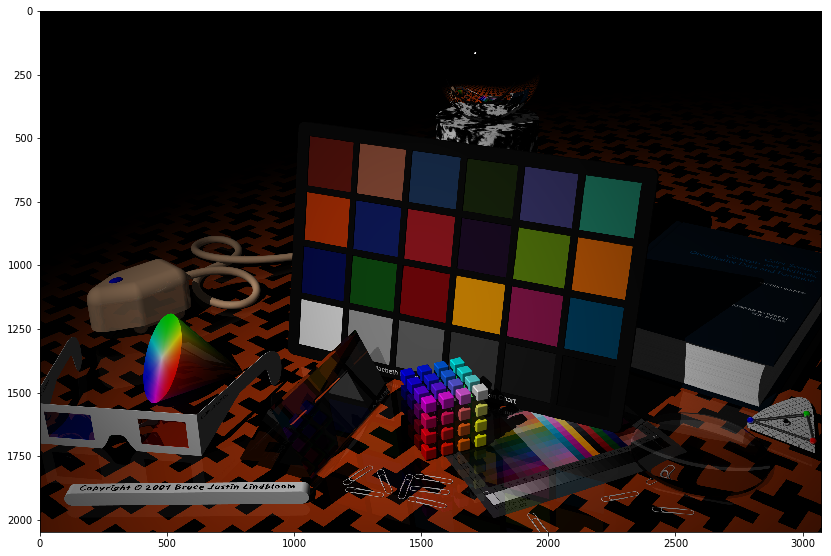

In [6]:
plt.figure(figsize=(14, 14))

# Divide all values by 65535 so we can display the image using matplotlib
plt.imshow(img / 65535)

In [7]:
def strong_tiff_aug(p=.5):
    return Compose([
        # albumentations supports uint8 and float32 inputs. For the latter, all
        # values must lie in the range [0.0, 1.0]. To apply augmentations, we
        # first use a `ToFloat()` transformation, which will inspect the data
        # type of the input image and convert the image to a float32 ndarray where
        # all values lie in the required range [0.0, 1.0].
        ToFloat(),
        
        # Alternatively, you can specify the maximum possible value for your input
        # and all values will be divided by it instead of using a predefined value
        # for a specific data type.       
        # ToFloat(max_value=65535.0),
        
        # Then we will apply augmentations
        RandomRotate90(),
        Flip(),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
        ], p=0.2),        
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.3),
        
        # You can convert the augmented image back to its original
        # data type by using `FromFloat`.
        # FromFloat(dtype='uint16'),

        # As in `ToFloat` you can specify a `max_value` argument and all input values
        # will be multiplied by it.
        # FromFloat(dtype='uint16', max_value=65535.0),

    ], p=p)

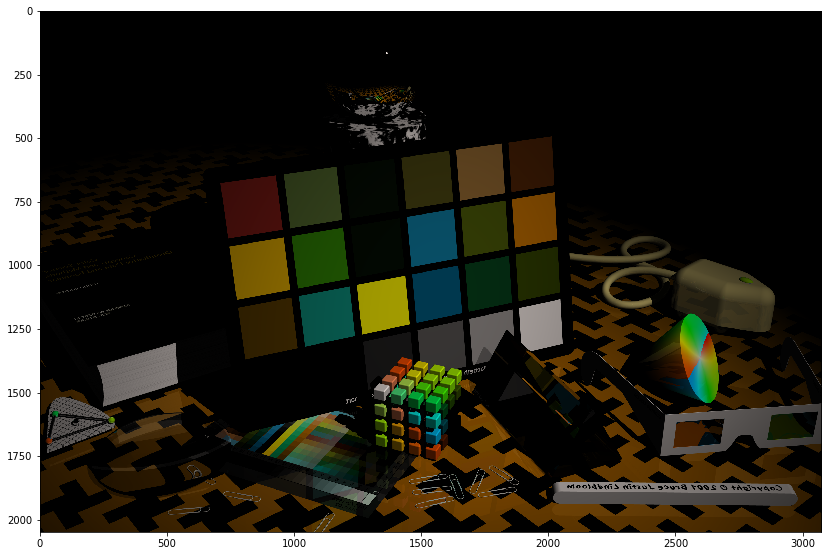

In [8]:
augmentation = strong_tiff_aug(p=0.9)
augmented = augmentation(image=img)
plt.figure(figsize=(14, 14))
plt.imshow(augmented['image'])